# **임대주택 단지 내 적정 주차수요 예측 대회**

In [232]:
PATH = r'C:\Users\Wyatt\wyatt37\data\parking'

In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import warnings
warnings.filterwarnings("ignore")

In [234]:
age_gender = pd.read_csv(PATH + '\\new_age_gender_info.csv')
train = pd.read_csv(PATH + '\\new_train.csv')
test = pd.read_csv(PATH + '\\new_test.csv')
sub = pd.read_csv(PATH + '\\new_sample_submission.csv')

# PREPROCESSING

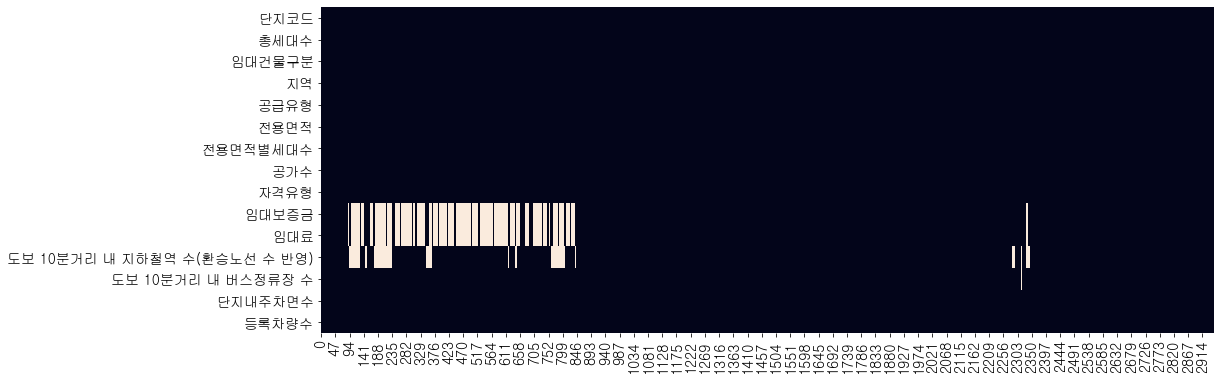

In [235]:
plt.figure(figsize=(16, 6))
sns.heatmap(train.isnull().T, cbar=False)
plt.show()

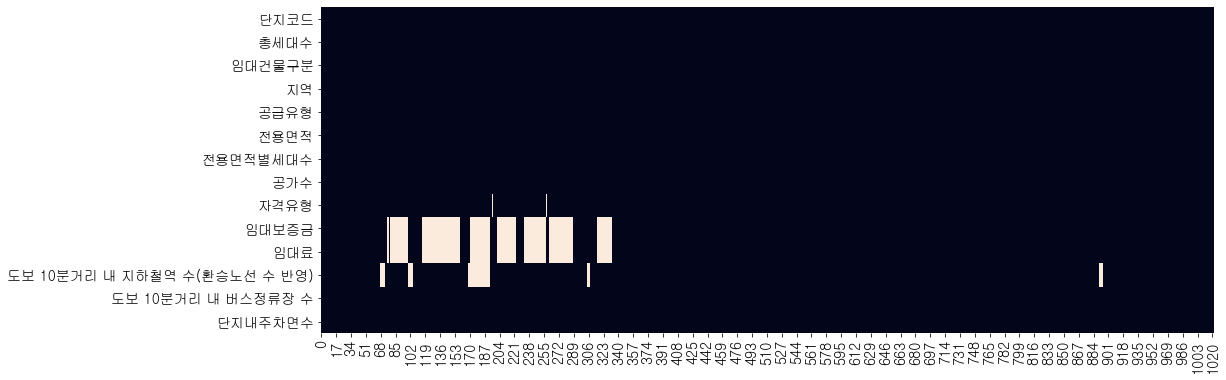

In [236]:
plt.figure(figsize=(16, 6))
sns.heatmap(test.isnull().T, cbar=False)
plt.show()

## FILLNA

### Subway

In [237]:
# train set에 지하철 정보가 없는 경남, 충남은 0으로 보간
train.loc[(train['지역'].isin(['경상남도', '충청남도'])) & (train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull()), '도보 10분거리 내 지하철역 수(환승노선 수 반영)'] = 0

In [238]:
# LH청약센터에서 찾은 주소로 확인한 대전의 8개 단지는 지하철이 없음
# 0으로 채워줍시다.

(train.loc[(train['지역'] == '대전광역시')
           & (train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull())
           , '도보 10분거리 내 지하철역 수(환승노선 수 반영)']) = 0

In [239]:
# test set에 지하철 정보가 없는 충남은 0으로 보간
test.loc[(test['지역'].isin(['충청남도'])) & (test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull()), '도보 10분거리 내 지하철역 수(환승노선 수 반영)'] = 0

In [240]:
# LH청약센터에서 찾은 주소로 확인한 대전의 2개 단지는 지하철이 없음
# 0으로 채워줍시다.

(test.loc[(test['지역'] == '대전광역시')
           & (test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull())
           & (test['임대건물구분'] != '상가'), '도보 10분거리 내 지하철역 수(환승노선 수 반영)']) = 0

### Bus

In [241]:
# 버스정류장 결측치는 train set에 1개 단지에 존재
# 해당 단지는 양산신도시LH아파트 5단지
# 지도를 확인한 결과 보수적으로 잡아도 7개 이상

train['도보 10분거리 내 버스정류장 수'] = train['도보 10분거리 내 버스정류장 수'].fillna(7)

### Rent

In [242]:
# test set 에 임대보증금과 임대료가 결측치인 1개 단지 존재
# 해당 단지는 대전둔산1단지주공아파트
# 공고문에 의거, 임대보증금과 임대료 아래와 같이 보간

test.loc[(test['임대건물구분'] != '상가') & (test['임대보증금'].isnull()), '임대보증금'] = [5787000, 5787000, 11574000]
test.loc[(test['임대건물구분'] != '상가') & (test['임대료'].isnull()), '임대료'] = [79980, 79980, 159960]

### Qualification

In [243]:
# C2411 아파트의 자격유형은 전부 A로 되어 있음.
# 동일하게 A로 보간

test.loc[(test['단지코드'] == 'C2411') & (test['자격유형'].isnull()), '자격유형'] = 'A'

In [244]:
# C2253 아파트의 자격유형은 전부 C로 되어 있음.
# 동일하게 C로 보간

test.loc[(test['단지코드'] == 'C2253') & (test['자격유형'].isnull()), '자격유형'] = 'C'

## VALUE PREPROCCESSING

### 총세대수, 전용면적별세대수 미일치 데이터 보간

In [245]:
# 경북혁신도시천년나무3단지
test.loc[test['단지코드'] == 'C2497', '전용면적별세대수'] = [114, 60, 275, 39]
# 속초청초아파트
train.loc[train['단지코드'] == 'C1206', '총세대수'] = 478
# 충무공동혁신도시LH아파트5단지
train.loc[train['단지코드'] == 'C2405', '전용면적별세대수'] = [100, 100, 400]
# 경북혁신LH천년나무2단지
train.loc[train['단지코드'] == 'C1740', '전용면적별세대수'] = [305, 126, 184, 168]
# LH강남아이파크
train.loc[train['단지코드'] == 'C1024', '전용면적별세대수'] = [195, 60, 15, 154, 99, 48, 42, 53, 29, 23]
# 서울서초A4BL
train.loc[train['단지코드'] == 'C1344', '전용면적별세대수'] = [106, 96, 41, 39, 42, 100]
# 남양주별내A1-3블록
train.loc[train['단지코드'] == 'C1804', '전용면적별세대수'] = [76, 82, 279, 28]
train = train.append({'단지코드': 'C1804',
              '총세대수': 478,
              '임대건물구분': '아파트',
              '지역': '경기도',
              '공급유형': '공공임대(10년)',
              '전용면적': 75.78,
              '전용면적별세대수': 13,
              '공가수': 3.0,
              '자격유형': 'A',
              '임대보증금': 78957000,
              '임대료': 530130,
              '도보 10분거리 내 지하철역 수(환승노선 수 반영)': 0.0,
              '도보 10분거리 내 버스정류장 수': 3.0,
              '단지내주차면수': 629.0,
              '등록차량수': 951.0}, ignore_index=True)
# 진천군 연미로 131 천년나무7단지
train.loc[train['단지코드'] == 'C1490', '전용면적별세대수'] = [105, 84, 472, 88]
# 나주빛가람LH3단지
train.loc[train['단지코드'] == 'C2620', '전용면적별세대수'] = [60, 227, 316, 160, 266]
# 대전대신2구역2단지
train = train.append({'단지코드': 'C2470', '총세대수': 636, '임대건물구분': '아파트', '지역': '대전광역시', '공급유형': '공공분양',
              '전용면적': 74.99, '전용면적별세대수': 72, '공가수': 1.0, '자격유형': 'A', '임대보증금': 225013300, '임대료': '-',
              '도보 10분거리 내 지하철역 수(환승노선 수 반영)': 1.0, '도보 10분거리 내 버스정류장 수': 2.0, '단지내주차면수': 772.0,
              '등록차량수': 887.0}, ignore_index=True)
train = train.append({'단지코드': 'C2470', '총세대수': 636, '임대건물구분': '아파트', '지역': '대전광역시', '공급유형': '공공분양',
              '전용면적': 74.95, '전용면적별세대수': 66, '공가수': 1.0, '자격유형': 'A', '임대보증금': 226278000, '임대료': '-',
              '도보 10분거리 내 지하철역 수(환승노선 수 반영)': 1.0, '도보 10분거리 내 버스정류장 수': 2.0, '단지내주차면수': 772.0,
              '등록차량수': 887.0}, ignore_index=True)
train = train.append({'단지코드': 'C2470', '총세대수': 636, '임대건물구분': '아파트', '지역': '대전광역시', '공급유형': '공공분양',
              '전용면적': 74.99, '전용면적별세대수': 92, '공가수': 1.0, '자격유형': 'A', '임대보증금': 230417000, '임대료': '-',
              '도보 10분거리 내 지하철역 수(환승노선 수 반영)': 1.0, '도보 10분거리 내 버스정류장 수': 2.0, '단지내주차면수': 772.0,
              '등록차량수': 887.0}, ignore_index=True)
#광주첨단H-2BL,H-3BL
train.loc[train['단지코드'] == 'C1970', '총세대수'] = 200
# 평택고덕Ca1, Ca2
train.loc[train['단지코드'] == 'C1894', '총세대수'] = 296

### Shop(상가세대수)

- 상가 세대수의 컬럼을 만들어주고, 다른 정보는 전부 버립니다. 어차피 집계에 노이즈만 생깁니다.

In [246]:
shop_temp = (train.loc[train['임대건물구분'] == '상가'].groupby(['단지코드'])['지역'].count()).reset_index().rename({'지역': '상가세대수'}, axis=1)

In [247]:
train = pd.merge(train.loc[train['임대건물구분'] == '아파트'], shop_temp, how='outer', on='단지코드').fillna(0)

In [248]:
train

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,상가세대수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0,0.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0,0.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0,0.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0,0.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2389,C2532,239,아파트,강원도,국민임대,49.20,19,7.0,A,11346000,116090,0.0,1.0,166.0,146.0,0.0
2390,C2532,239,아파트,강원도,국민임대,51.08,34,7.0,A,14005000,142310,0.0,1.0,166.0,146.0,0.0
2391,C2532,239,아파트,강원도,국민임대,51.73,34,7.0,A,14005000,142310,0.0,1.0,166.0,146.0,0.0
2392,C2532,239,아파트,강원도,국민임대,51.96,114,7.0,A,14005000,142310,0.0,1.0,166.0,146.0,0.0


### StdDeposit(환산보증금)

In [249]:
train.loc[train['임대보증금'] == '-', '임대보증금'] = 0
test.loc[test['임대보증금'] == '-', '임대보증금'] = 0

train.loc[train['임대료'] == '-', '임대료'] = 0
test.loc[test['임대료'] == '-', '임대료'] = 0

In [250]:
# nan 값 때문에 object로 되어 있습니다. 일단 0으로 채워 줍니다.
train['임대보증금'] = train['임대보증금'].fillna(0)
test['임대보증금'] = test['임대보증금'].fillna(0)

train['임대료'] = train['임대료'].fillna(0)
test['임대료'] = test['임대료'].fillna(0)

In [251]:
# 계산을 위해서 int로 바꿔줍니다.
train['임대보증금'] = train['임대보증금'].astype(int)
test['임대보증금'] = test['임대보증금'].astype(int)

train['임대료'] = train['임대료'].astype(int)
test['임대료'] = test['임대료'].astype(int)

- 환산보증금은 보증금 + 임대료 * 100 입니다.

In [168]:
# # 환산보증금 컬럼을 만들어줍니다.
# train['환산보증금'] = train['임대보증금'] + train['임대료'] * 100
# test['환산보증금'] = test['임대보증금'] + test['임대료'] * 100

In [169]:
# # 제곱미터당 환산보증금을 만들어줍니다.
# train['면적당환산보증금'] = (train['환산보증금'] / train['전용면적']).round()
# test['면적당환산보증금'] = (test['환산보증금'] / test['전용면적']).round()

- 임대료가 없는 아파트를 찾아서 값을 넣어주겠습니다.

In [170]:
# # C1350은 같은 단지에 다른 임대보증금, 임대료가 있습니다.
# train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'] == 0), '면적당환산보증금'] = train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'] != 0)]['면적당환산보증금'].mean()

In [171]:
# # C1786은 같은 단지에 다른 임대보증금, 임대료가 있습니다.
# train.loc[(train['단지코드'] == 'C1786') & (train['임대보증금'] == 0), '면적당환산보증금'] = train.loc[(train['단지코드'] == 'C1786') & (train['임대보증금'] != 0)]['면적당환산보증금'].mean()

In [172]:
# # C2186은 같은 단지에 다른 임대보증금, 임대료가 있습니다.
# train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'] == 0), '면적당환산보증금'] = train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'] != 0)]['면적당환산보증금'].mean()

In [173]:
# # C1326은 비슷한 유형의 단지를 찾아 평균값으로 넣겠습니다.
# train.loc[train['단지코드'] == 'C1326', '면적당환산보증금'] = train.loc[(train['지역'] == '부산광역시')
#                                                                       & (train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] == 0)
#                                                                       & (train['임대건물구분'] != '상가')
#                                                                       & (train['공급유형'] == '국민임대')
#                                                                       & (train['단지코드'] != 'C1326')]['면적당환산보증금'].mean()

In [174]:
# # C1267은 같은 단지에 다른 임대보증금, 임대료가 있습니다.
# test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'] == 0), '면적당환산보증금'] = test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'] != 0)]['면적당환산보증금'].mean()

In [175]:
# # C2152은 비슷한 유형의 단지를 찾아 평균값으로 넣겠습니다.
# test.loc[test['단지코드'] == 'C2152', '면적당환산보증금'] = test.loc[(test['지역'] == '강원도')
#                                                                   & (test['임대건물구분'] != '상가')
#                                                                   & (test['공급유형'] == '영구임대')
#                                                                   & (test['단지코드'] != 'C2152')]['면적당환산보증금'].mean()

### Test NEW StdDeposit

기존의 환산보증금 공식으로 가면, 전세금과 환산보증금 차이가 너무 심합니다.<br>
전세와 월세가 동시에 있는 단지가 1개 있습니다. 이 단지를 기준으로 환산보증금을 재계산 합니다.

In [292]:
train.loc[train['임대보증금'] > 100000000]

,단지코드,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,상가세대수,new환산보증금,new면적당환산보증금,총세대수,전용면적구분,실거주세대수
1397,C1344,아파트,0,공공임대(분납),74.97,41,0.0,A,125326000,317660,0.0,3.0,467.0,509.0,0.0,237777640,3171637.0,424,중형,424.0
1398,C1344,아파트,0,공공임대(분납),84.95,39,0.0,A,143545000,363840,0.0,3.0,467.0,509.0,0.0,272344360,3205937.0,424,대형,424.0
1399,C1344,아파트,0,공공임대(분납),84.97,42,0.0,A,145264000,368190,0.0,3.0,467.0,509.0,0.0,275603260,3243536.0,424,대형,424.0
1400,C1344,아파트,0,공공임대(분납),84.99,100,0.0,A,142744000,361800,0.0,3.0,467.0,509.0,0.0,270821200,3186507.0,424,대형,424.0
1453,C1328,아파트,1,국민임대,46.49,69,36.0,E,123711000,64430,0.0,15.0,871.0,770.0,0.0,146519220,3151629.0,992,중형,956.0
1454,C1328,아파트,1,국민임대,46.49,63,36.0,E,123711000,64430,0.0,15.0,871.0,770.0,0.0,146519220,3151629.0,992,중형,956.0
1455,C1328,아파트,1,국민임대,46.61,92,36.0,E,123711000,64430,0.0,15.0,871.0,770.0,0.0,146519220,3143515.0,992,중형,956.0
1456,C1328,아파트,1,국민임대,46.61,38,36.0,E,123711000,64430,0.0,15.0,871.0,770.0,0.0,146519220,3143515.0,992,중형,956.0
1457,C1328,아파트,1,국민임대,51.75,128,36.0,E,144496000,75250,0.0,15.0,871.0,770.0,0.0,171134500,3306947.0,992,중형,956.0
1458,C1328,아파트,1,국민임대,51.75,32,36.0,E,144496000,75250,0.0,15.0,871.0,770.0,0.0,171134500,3306947.0,992,중형,956.0


반대로 환산보증금이 아닌, 환산임대료로 가는 것도 나쁘지 않습니다.

In [253]:
(187694000/51.32) - ((45456000 + (356420 * 354))/46.96)

2542.080887400545

In [254]:
# 환산보증금 컬럼을 만들어줍니다.
train['new환산보증금'] = train['임대보증금'] + train['임대료'] * 354
test['new환산보증금'] = test['임대보증금'] + test['임대료'] * 354

In [255]:
# 제곱미터당 환산보증금을 만들어줍니다.
train['new면적당환산보증금'] = (train['new환산보증금'] / train['전용면적']).round()
test['new면적당환산보증금'] = (test['new환산보증금'] / test['전용면적']).round()

- 임대료가 없는 아파트를 찾아서 값을 넣어주겠습니다.

In [256]:
# C1350은 같은 단지에 다른 임대보증금, 임대료가 있습니다.
train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'] == 0), 'new면적당환산보증금'] = train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'] != 0)]['new면적당환산보증금'].mean()

In [257]:
# C1786은 같은 단지에 다른 임대보증금, 임대료가 있습니다.
train.loc[(train['단지코드'] == 'C1786') & (train['임대보증금'] == 0), 'new면적당환산보증금'] = train.loc[(train['단지코드'] == 'C1786') & (train['임대보증금'] != 0)]['new면적당환산보증금'].mean()

In [258]:
# C2186은 같은 단지에 다른 임대보증금, 임대료가 있습니다.
train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'] == 0), 'new면적당환산보증금'] = train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'] != 0)]['new면적당환산보증금'].mean()

In [259]:
# C1326은 비슷한 유형의 단지를 찾아 평균값으로 넣겠습니다.
train.loc[train['단지코드'] == 'C1326', 'new면적당환산보증금'] = train.loc[(train['지역'] == '부산광역시')
                                                                      & (train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] == 0)
                                                                      & (train['임대건물구분'] != '상가')
                                                                      & (train['공급유형'] == '국민임대')
                                                                      & (train['단지코드'] != 'C1326')]['new면적당환산보증금'].mean()

In [260]:
# C1267은 같은 단지에 다른 임대보증금, 임대료가 있습니다.
test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'] == 0), 'new면적당환산보증금'] = test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'] != 0)]['new면적당환산보증금'].mean()

In [261]:
# C2152은 비슷한 유형의 단지를 찾아 평균값으로 넣겠습니다.
test.loc[test['단지코드'] == 'C2152', 'new면적당환산보증금'] = test.loc[(test['지역'] == '강원도')
                                                                  & (test['임대건물구분'] != '상가')
                                                                  & (test['공급유형'] == '영구임대')
                                                                  & (test['단지코드'] != 'C2152')]['new면적당환산보증금'].mean()

### Units(총세대수)

In [262]:
# 전용면적별세대수를 합쳐서 총 세대수를 다시 넣어주겠습니다.
temp = train.groupby(['단지코드'])['전용면적별세대수'].sum().reset_index().rename({'전용면적별세대수': '총세대수'}, axis=1)
train = pd.merge(train.loc[:, ~train.columns.isin(['총세대수'])], temp, on='단지코드')

In [263]:
# 전용면적별세대수를 합쳐서 총 세대수를 다시 넣어주겠습니다.
temp = test.groupby(['단지코드'])['전용면적별세대수'].sum().reset_index().rename({'전용면적별세대수': '총세대수'}, axis=1)
test = pd.merge(test.loc[:, ~test.columns.isin(['총세대수'])], temp, on='단지코드')

### RecruitType(공급유형)

In [264]:
# # 공공분양이 있는 1개 단지는 동일 단지의 공공임대로 맞춰주겠습니다.
# train.loc[train['공급유형'] == '공공분양', '공급유형'] = '공공임대'

In [265]:
# # 장기전세가 있는 1개 단지는 유사 유형의 행복주택으로 맞춰주겠습니다.
# train.loc[train['공급유형'] == '장기전세', '공급유형'] = '행복주택'

In [266]:
# # 공공임대(5년, 10년, 50년)는 햇수는 다르지만, 하나로 묶어주는 겠습니다.
# train.loc[train['공급유형'].str.contains('공공임대'), '공급유형'] = '공공임대'
# test.loc[test['공급유형'].str.contains('공공임대'), '공급유형'] = '공공임대'

### UnitType(전용면적구분)

In [267]:
# 80 ~ 은 대형
# 40 ~ 80 은 중형
# ~ 40 은 소형

train.loc[train['전용면적'] < 40, '전용면적구분'] = '소형'
train.loc[train['전용면적'] >= 40, '전용면적구분'] = '중형'
train.loc[train['전용면적'] >= 80, '전용면적구분'] = '대형'

test.loc[test['전용면적'] < 40, '전용면적구분'] = '소형'
test.loc[test['전용면적'] >= 40, '전용면적구분'] = '중형'
test.loc[test['전용면적'] >= 80, '전용면적구분'] = '대형'

### Residence(실거주)

In [268]:
# 공가수를 빼준 실거주 수를 만들어줍니다.
train['실거주세대수'] = train['총세대수'] - train['공가수']
test['실거주세대수'] = test['총세대수'] - test['공가수']

### Region

In [269]:
# 실거주세대 대비 차량수의 지역 평균으로 오름차순 정렬
# Order를 주었습니다.
region_dict = {'서울특별시': 0,
               '경기도':1,
               '세종특별자치시':2,
               '경상북도':3,
               '대구광역시':4,
               '광주광역시':5,
               '충청북도':6,
               '전라남도':7,
               '전라북도':8,
               '강원도':9,
               '경상남도':10,
               '울산광역시':11,
               '제주특별자치도':12,
               '대전광역시':13,
               '충청남도':14,
               '부산광역시':15}

In [270]:
train['지역'] = train['지역'].map(region_dict)
test['지역'] = test['지역'].map(region_dict)

### Qualification

In [271]:
# 상가가 아닌데 D형이 있습니다.

# 같은 단지에 A형이 있으므로 A로 넣어주겠습니다.
train.loc[(train['임대건물구분'] != '상가') & (train['자격유형'] == 'D'), '자격유형'] = 'A'

# 같은 단지에 C형이 있으므로 C로 넣어주겠습니다.
test.loc[(test['임대건물구분'] != '상가') & (test['자격유형'] == 'D'), '자격유형'] = 'C'

In [272]:
# # F는 단 3개의 row가 있습니다. 동일 단지의 C형으로 바꾸겠습니다.
# train.loc[train['자격유형'] == 'F', '자격유형'] = 'C'

# # O는 단 1개의 row가 있습니다. 동일 단지의 N형으로 바꾸겠습니다.
# train.loc[train['자격유형'] == 'O', '자격유형'] = 'N'

In [273]:
# # B형은 조금 어렵습니다. 일단은 C로 바꾸었는데, 나중에 조정을 해야할 것 같습니다.
# train.loc[train['자격유형'] == 'B', '자격유형'] = 'C'

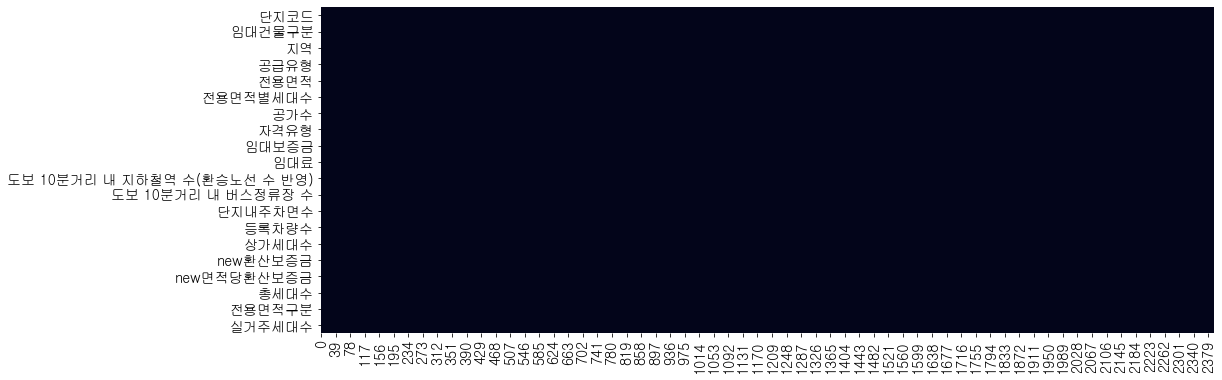

In [274]:
plt.figure(figsize=(16, 6))
sns.heatmap(train.isnull().T, cbar=False)
plt.show()

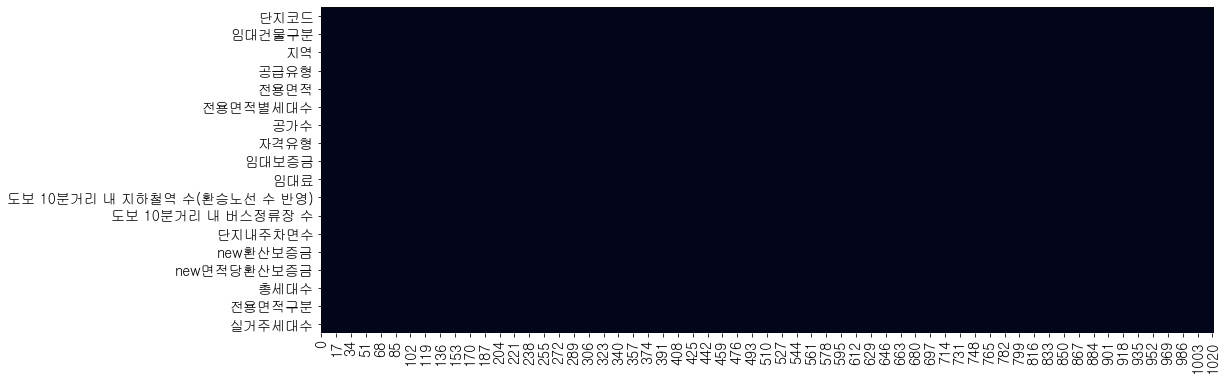

In [275]:
plt.figure(figsize=(16, 6))
sns.heatmap(test.isnull().T, cbar=False)
plt.show()

In [291]:
(train.groupby(['단지코드'])['전용면적별세대수'].sum().to_frame().values - train[['단지코드', '총세대수']].drop_duplicates().set_index(['단지코드']).sort_index().values).sum()

0

# MODELING

In [199]:
def make_train_test(train):

    train_preprocessed = train.copy()

    train_preprocessed.drop(['전용면적', '공가수', '임대보증금', '임대료', '환산보증금', '총세대수'], axis=1, inplace=True)
    train_preprocessed = train_preprocessed.loc[train_preprocessed['임대건물구분'] == '아파트', ~train_preprocessed.columns.isin(['임대건물구분'])]

    temp = train_preprocessed.groupby(['단지코드', '전용면적구분'])['전용면적별세대수'].sum().unstack().fillna(0)
    train_preprocessed = pd.merge(train_preprocessed.loc[:, ~train_preprocessed.columns.isin(['전용면적구분'])], temp, on='단지코드')

    temp = train_preprocessed.groupby(['단지코드', '공급유형'])['전용면적별세대수'].sum().unstack().fillna(0)
    train_preprocessed = pd.merge(train_preprocessed.loc[:, ~train_preprocessed.columns.isin(['공급유형'])], temp, on='단지코드')

    temp = train_preprocessed.groupby(['단지코드', '자격유형'])['전용면적별세대수'].sum().unstack().fillna(0)
    train_preprocessed = pd.merge(train_preprocessed.loc[:, ~train_preprocessed.columns.isin(['자격유형', '전용면적별세대수'])], temp, on='단지코드')

    temp = train_preprocessed.groupby(['단지코드'])['면적당환산보증금'].mean().reset_index()
    train_preprocessed = pd.merge(train_preprocessed.loc[:, ~train_preprocessed.columns.isin(['면적당환산보증금'])], temp, on='단지코드')

    train_preprocessed = train_preprocessed.drop_duplicates()
    
    #train_preprocessed.drop(['단지코드'], axis=1, inplace=True)
    
    return train_preprocessed

In [200]:
def make_train_test(train):

    train_preprocessed = train.copy()

    train_preprocessed.drop(['전용면적', '공가수', '임대보증금', '임대료', 'new환산보증금', '총세대수'], axis=1, inplace=True)
    train_preprocessed = train_preprocessed.loc[train_preprocessed['임대건물구분'] == '아파트', ~train_preprocessed.columns.isin(['임대건물구분'])]

    temp = train_preprocessed.groupby(['단지코드', '전용면적구분'])['전용면적별세대수'].sum().unstack().fillna(0)
    train_preprocessed = pd.merge(train_preprocessed.loc[:, ~train_preprocessed.columns.isin(['전용면적구분'])], temp, on='단지코드')

    temp = train_preprocessed.groupby(['단지코드', '공급유형'])['전용면적별세대수'].sum().unstack().fillna(0)
    train_preprocessed = pd.merge(train_preprocessed.loc[:, ~train_preprocessed.columns.isin(['공급유형'])], temp, on='단지코드')

    temp = train_preprocessed.groupby(['단지코드', '자격유형'])['전용면적별세대수'].sum().unstack().fillna(0)
    train_preprocessed = pd.merge(train_preprocessed.loc[:, ~train_preprocessed.columns.isin(['자격유형', '전용면적별세대수'])], temp, on='단지코드')

    temp = train_preprocessed.groupby(['단지코드'])['new면적당환산보증금'].mean().reset_index()
    train_preprocessed = pd.merge(train_preprocessed.loc[:, ~train_preprocessed.columns.isin(['new면적당환산보증금'])], temp, on='단지코드')

    train_preprocessed = train_preprocessed.drop_duplicates()
    
    #train_preprocessed.drop(['단지코드'], axis=1, inplace=True)
    
    return train_preprocessed

In [201]:
X = make_train_test(train)
y = make_train_test(test)

In [202]:
X.columns

Index(['단지코드', '지역', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수',
       '단지내주차면수', '등록차량수', '실거주세대수', '대형', '소형', '중형', '공공분양', '공공임대(10년)',
       '공공임대(50년)', '공공임대(5년)', '공공임대(분납)', '국민임대', '영구임대', '장기전세', '행복주택',
       'A', 'B', 'C', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O',
       'new면적당환산보증금'],
      dtype='object')

In [203]:
y.columns

Index(['단지코드', '지역', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수',
       '단지내주차면수', '실거주세대수', '대형', '소형', '중형', '공공임대(10년)', '공공임대(50년)',
       '공공임대(분납)', '국민임대', '영구임대', '행복주택', 'A', 'C', 'E', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'new면적당환산보증금'],
      dtype='object')

In [204]:
set(X.columns).difference(y.columns)

{'B', 'F', 'O', '공공분양', '공공임대(5년)', '등록차량수', '장기전세'}

In [205]:
y['공공분양'] = 0
y['공공임대(5년)'] = 0
y['장기전세'] = 0

In [206]:
y['B'] = 0
y['F'] = 0
y['O'] = 0

In [207]:
X.shape, y.shape

((423, 34), (150, 33))

In [208]:
X.drop(['B', 'F', 'O'], axis=1, inplace=True)
y.drop(['B', 'F', 'O'], axis=1, inplace=True)

In [209]:
from sklearn.ensemble import RandomForestRegressor

In [210]:
x_train = X.loc[:, ~X.columns.isin(['단지코드', '등록차량수'])]
y_train = X['등록차량수']
x_test = y.loc[:, ~y.columns.isin(['단지코드'])]

In [211]:
rf = RandomForestRegressor(random_state=42, oob_score=True, criterion='mse', n_estimators=200)
rf.fit(x_train, y_train)
pred = rf.predict(x_test)

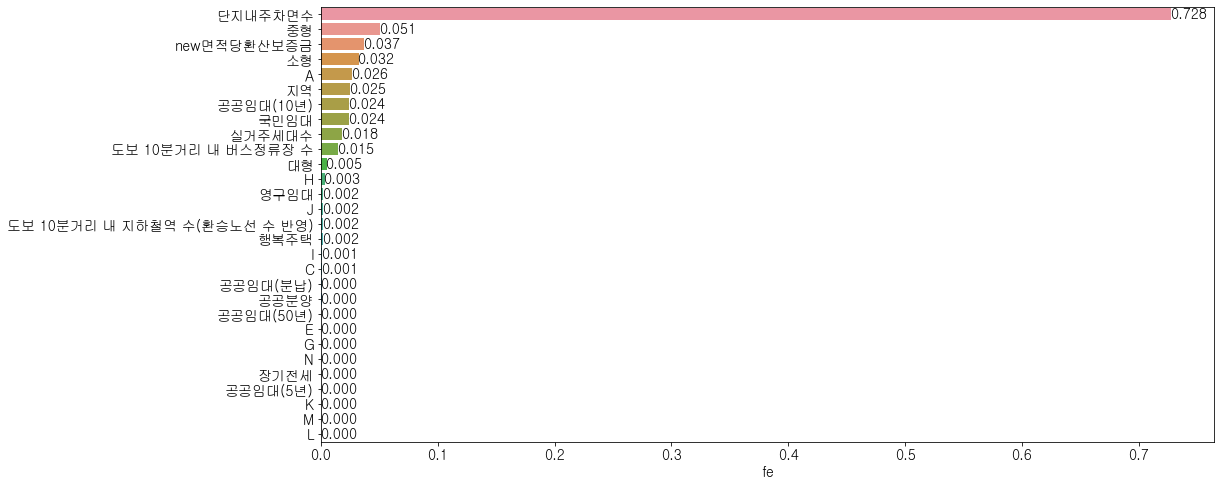

In [212]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(rf.feature_importances_,
                      index=x_train.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(16, 8))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

In [213]:
rf.oob_score_

0.7730176252556606

In [214]:
sub.num = pred

In [215]:
sub.to_csv('submission/parking_210617_vanilaRF_testNewStdDeposit+noShop+noChangeRecruitType.csv', index=False)

#### 210615 실험

1. 소수의 데이터를 다수의 데이터로 바꾸고 모델링
2. 소수의 데이터를 그대로 두고, test set에 빈 컬럼을 만들어서라도 모델링
3. 소수의 데이터를 그대로 두고, drop 해버리고 모델링

결론: 3번이 우세

#### 210616 실험

- 전 실험을 MAE에서 MSE로 똑같이 진행

결론: MSE가 우세

#### 210617 실험

1. new환산보증금: 114.9096
2. 상가를 빼고 집계: 결과가 같다. 상가를 넣지 않고 하고 있었다.
3. 공급유형을 그대로 두고, test set에 빈 컬럼을 만들기 : 131.316

#### 210618 실험

1. 공급유형을 그대로 두고, drop 해버리고 모델링
2. ㅇㅇ
3. ㅇㅇ

- 지역을 age_gender를 활용해서 넣어주고 싶습니다.
- 전용면적구분을 바꾸는 것도 고민하고 있습니다.

환산보증금에 대해서 다시 고민해봐야겠습니다.
- 전세금만 있는 단지...